# Neural Network
The algoritm shown here accomodates 1 hidden layer (with arbitrary number of nodes) and an output layer (with arbitrary number of nodes).

```
param.  hidden  output
        layer

         O
        
O        O        O

O        O        O

...      ...      ...

O        O        O

         O
```

In [1]:
# imports and plot customizations
import os
import sys
import pickle
import collections
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import time

class TimeClass():
    def __init__(self):
        pass
    def __enter__(self):
        self.start = time.time()
    def __exit__(self, type, value, traceback):
        self.end = time.time()
        self.elapsed = round(self.end - self.start, 2)
        print('\nFinished executing in {} seconds\n'.format(self.elapsed))

In [3]:
matplotlib.rcParams['xtick.color'] = 'grey'
matplotlib.rcParams['ytick.color'] = 'grey'
matplotlib.rcParams['xtick.major.size'] = 7
matplotlib.rcParams['ytick.major.size'] = 7
# matplotlib.rcParams['xtick.labelsize'] = 10
# matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['xtick.minor.bottom'] = False
matplotlib.rcParams['ytick.minor.left'] = False
matplotlib.rcParams['figure.titlesize'] = 15
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['axes.labelcolor'] = 'grey'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['xtick.major.pad'] = 8
matplotlib.rcParams['ytick.major.pad'] = 8
matplotlib.rcParams['legend.frameon'] = False
matplotlib.rcParams['axes.edgecolor'] = 'grey'
matplotlib.rcParams['text.color'] = 'grey'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['legend.loc'] = 'upper left'
matplotlib.rcParams['figure.constrained_layout.h_pad'] = 0.12
matplotlib.rcParams['figure.constrained_layout.w_pad'] = 0.12

In [384]:
class neural_network:
    '''
    Arguments: 
        epoch_size (scalar, default = 1e2)
        alpha (scalar, default = 1e-3)
        hiddel_layer_dimension (integer, default = 10)
        dropout (boolean, default = True, whether to use the dropout regularization)
        dropout_probability (0 < float < 1)
        seed (numpy seed, default None)
        batch_size (integer, size of the minibatch, default = 1)
    '''
    
    def __init__(self, **kwargs):
        self.epoch_size = int(kwargs.get('epoch_size', 1e2))
        self.alpha = kwargs.get('alpha', 1e-3)
        self.hidden_layer_dimension = kwargs.get('hidden_layer_dimension', 10)
        self.dropout = kwargs.get('dropout', True)
        self.dropout_probability = kwargs.get('dropout_probability', 0.5)
        self.seed = kwargs.get('seed', None)
        self.batch_size = kwargs.get('batch_size', 1)
        
        
    def __repr__(self):
        return f'\
        neural_network(\
        epoch_size = {self.epoch_size}, \
        alpha = {self.alpha}, \
        hidden_layer_dimension = {self.hidden_layer_dimension}, \
        dropout = {self.dropout}, \
        dropout_probability = {self.dropout_probability}, \
        seed = {self.seed} \
        batch_size = {self.batch_size}\
        )'
        
    def _relu(self, x):
        return (x > 0) * x
    
    def _relu_active_binary(self, x):
        return np.int8(x > 0)
    
    def _split_data(self, X, y):
        # shuffle the dataset
        idx = np.random.choice(np.arange(X.shape[0]), X.shape[0], replace = False)
        X = X[idx]
        y = y[idx]
        # split
        batches = int(X.shape[0] / self.batch_size)
        idx = np.int32(np.linspace(0, X.shape[0], batches, endpoint = True))
        idx = zip(idx[:-1], idx[1:])
        X_y_batches = [(X[start:end], y[start:end]) for start, end in idx]
        return X_y_batches
    
    def _dropout_mask(self, shape):
        mask = np.random.choice(
                        [0,1], 
                        shape, 
                        p = [self.dropout_probability, 1 - self.dropout_probability]
        )
        return mask
     
    def fit(self, X, y):  
        '''
        X (input matrix)
        y (response variable, must be matrix, if for regression, add a dimension to the vector y[:, np.newaxis])
        '''
        if self.seed:
            np.random.seed(self.seed)
            
        weight_list = []
        error_list = []
        train_accuracy_list = []

        weights_0_1 = np.random.random((X.shape[1], self.hidden_layer_dimension)) * 0.2 - 0.1
        weights_1_2 = np.random.random((self.hidden_layer_dimension, y.shape[1])) * 0.2 - 0.1

        for epoch in range(self.epoch_size):
            
            for X_batch, y_batch in self._split_data(X, y):
                # dot products
                layer_1 = self._relu(np.matmul(X_batch, weights_0_1)) 
                if self.dropout:
                    mask = self._dropout_mask(layer_1.shape)
                    layer_1 *= mask * 1/self.dropout_probability  # * 1/x to compensate for the fact that x of the nodes are 0 
                layer_2 = np.matmul(layer_1, weights_1_2) 

                # Deltas and backpropagation
                layer_2_delta = layer_2 - y_batch
                layer_1_delta = layer_2_delta.dot(weights_1_2.T) * self._relu_active_binary(layer_1)
                if self.dropout:
                    layer_1_delta *= mask

                # Weights update
                weights_0_1 -= self.alpha * X_batch.T.dot(layer_1_delta)
                weights_1_2 -= self.alpha * layer_1.T.dot(layer_2_delta)
                weight_list.append([weights_0_1, weights_1_2])
            
            # Classification scores
            epoch_prediction = np.matmul(
                self._relu(np.matmul(X, weights_0_1)),
                weights_1_2
            )
            train_accuracy = np.sum(np.argmax(epoch_prediction, axis = 1) == np.argmax(y, axis = 1))  / X.shape[0]
            train_accuracy_list.append(train_accuracy)
            error = np.sum(np.linalg.norm(epoch_prediction - y, axis = 1) ** 2)
            error_list.append(error)
            
            sys.stdout.write(
                "\r" +
                " Epoch:" + str(epoch + 1) + "/" + str(self.epoch_size) +
                ", Error (Sum of sq.):" + str(error)[0:5] + 
                ", Train accuracy:" + str(train_accuracy)
                )

        # Object update
        self.train_X = X
        self.train_y = y
        self.train_prediction = epoch_prediction
        self.train_prediction_vector = np.argmax(self.train_prediction, axis = 1)
        self.train_y_vector = np.argmax(y, axis = 1)
        self.train_error = error_list
        self.weight_list = weight_list
        self.train_accuracy = train_accuracy_list
        self.weight = weight_list[-1]
        
    def predict(self, X):
        self.test_prediction = np.matmul(
            self._relu(np.matmul(X, self.weight[0])),
            self.weight[1]
        )
        self.test_prediction_vector = np.argmax(self.test_prediction, axis = 1)
        
    
    def score_prediction(self, y, type = 'classification'):
        '''
        type ('classification' or 'sum_of_squares', default: 'classification')
        '''
        self.test_y = y
        self.test_y_vector = np.argmax(y, axis = 1)
        
        if not 'test_prediction' in dir(self):
            raise NameError('test_prediction object not found')
        
        if type == 'classification':
            correct_count = np.argmax(self.test_prediction, axis = 1) == np.argmax(y, axis = 1)
            test_score = np.sum(correct_count) / y.shape[0]
            self.test_score = test_score
            return test_score
        
        elif type == 'sum_of_squares':
            delta = self.test_prediction - y
            squares = np.linalg.norm(delta, axis = 1) **2
            sum_of_squares = np.sum(squares)
            self.test_score = sum_of_squares
            return sum_of_squares
        
    def plot_train_sum_of_squares(self):
        _, ax = plt.subplots(1,1, figsize = (4, 4))
        ax.plot(self.train_error, color = 'grey')
        ax.set_xlabel('Epoch', color = 'grey', fontsize = 15)
        ax.set_ylabel('Sum of squares', color = 'grey', fontsize = 15)

    def plot_train_sum_of_squares_vs_classification_accuracy(self):
        _, ax = plt.subplots(1,1, figsize = (4, 4))
        ax.plot(self.train_error, self.train_accuracy, color = 'grey')
        ax.set_xlabel('Sum of squares', color = 'grey', fontsize = 15)
        ax.set_ylabel('Accuracy', color = 'grey', fontsize = 15)
        
    def classification_heatmap(self, dataset = 'train', cmap = 'PRGn'):
        '''
        dataset ('train' or 'test' default = 'train')
        '''        
        tab1 = pd.crosstab(
            eval('self.'+dataset+'_y_vector'), 
            eval('self.'+dataset+'_prediction_vector'), 
            rownames = [dataset +' y'], colnames = [dataset + ' prediction'])

        fig, ax = plt.subplots(1,1,figsize = (5,5))
        im = ax.imshow(tab1.values,  cmap = cmap)

        for i in range(tab1.shape[0]):
            for j in range(tab1.shape[1]):
                text = ax.text(x = j, y = i, s = tab1.values[i, j], ha = "center", va = "center", color = "w")

        ax.set_xticks(range(tab1.shape[0]))
        ax.set_yticks(range(tab1.shape[0]))
        ax.set_xticklabels(range(tab1.shape[0]))
        ax.set_yticklabels(range(tab1.shape[0]))
        ax.set_ylabel(dataset + ' prediction', color = 'grey', fontsize= 15)
        ax.set_xlabel(dataset + ' y', color = 'grey', fontsize= 15)

        for edge, spine in ax.spines.items():
            spine.set_visible(False)

        ax.tick_params(which="minor", bottom=False, left=False)
        ax.set_xticks((np.arange(tab1.shape[0]) + 0.5)[:-1], minor=True)
        ax.set_yticks((np.arange(tab1.shape[0]) + 0.5)[:-1], minor=True)

        ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    
    def boxplot_sum_of_squares_vs_class(self, dataset = 'train'):
        '''
        Only for single output node networks.
        dataset ('train' or 'test' default = 'train')
        '''
        dataset_test = pd.concat(
            [pd.Series(np.squeeze(eval('self.'+dataset+'_prediction'))), pd.Series(np.squeeze(eval('self.'+dataset+'_y')))], 
            axis = 1,
            keys = ['predicted', 'y']
        )
        bp1 = tuple(zip(*[[gr.predicted.values, nm] for nm, gr in dataset_test.groupby('y')]))
        
        _, ax = plt.subplots(1,1, figsize = (1.5,3))

        ax.boxplot(
            x = bp1[0],
            labels = bp1[1],
            widths = 0.6,
            capprops = dict(color='grey'), 
            boxprops = dict(color='grey'),
            whiskerprops = dict(color='grey'), 
            medianprops = {'color':'grey', 'linewidth':'2'}
        )

        ax.set_ylabel(dataset + ' prediction', color = 'grey', fontsize = 15)
        ax.set_xlabel(dataset+' y', color = 'grey', fontsize = 15)

Linearly separable example

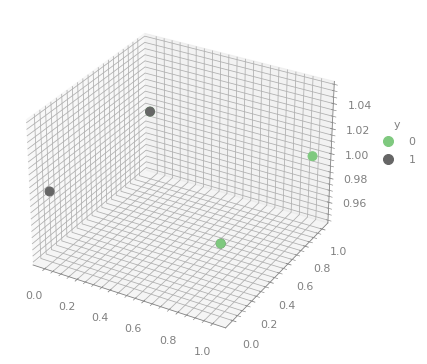

In [4]:
X = np.array( 
    [[ 1, 0, 1 ],
     [ 0, 1, 1 ],
     [ 0, 0, 1 ],
     [ 1, 1, 1 ],
     [ 0, 1, 1 ],
     [ 1, 0, 1 ] ] 
)

y = np.array( [ 0, 1, 0, 1, 1, 0 ] )

fig = plt.figure(constrained_layout=True, figsize = (15, 5))
ax = fig.add_subplot(1,1,1, projection='3d')
pl1 = ax.scatter(xs = X[:, 0], ys = X[:, 1], zs = X[:, 2], zdir = 'z', s = 80, c = y, cmap = 'Accent', depthshade = False)
ax.legend(
    *pl1.legend_elements(prop='colors', num = 1, size = 10),
    bbox_to_anchor = (1.05, 0.7),
    loc = 'upper left', 
    frameon=False,
    title = 'y'
)

Non-linearly separable example

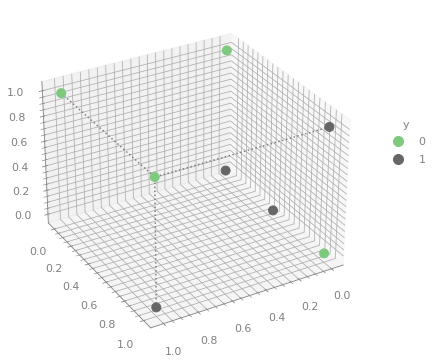

In [3]:
X = np.array( 
    [ [ 1, 0, 1 ],
      [ 0, 1, 1 ],
      [ 0, 0, 1 ],
      [ 1, 1, 1 ],
      [ 0, 0, 0 ],
      [ 0, 1, 0 ],
      [ 0,.5, 0 ],
      [ 1, 1, 0] ] 
)

y = np.array([1, 1, 0, 0, 0, 1, 1, 0])
y = np.expand_dims(y, axis = 1)

fig = plt.figure(constrained_layout=True, figsize = (15, 5))

ax = fig.add_subplot(1,2,1, projection='3d')
pl1 = ax.scatter(xs = X[:, 0], ys = X[:, 1], zs = X[:, 2], zdir = 'z', s = 80, c = np.squeeze(y), cmap = 'Accent', depthshade = False)
ax.plot(xs = [1, 1], ys = [1, 1], zs = [0, 1], color = 'grey', linestyle = 'dotted')
ax.plot(xs = [0, 1], ys = [1, 1], zs = [1, 1], color = 'grey', linestyle = 'dotted')
ax.plot(xs = [1, 1], ys = [0, 1], zs = [1, 1], color = 'grey', linestyle = 'dotted')

ax.legend(
    *pl1.legend_elements(prop='colors', num = 1, size = 10),
    bbox_to_anchor = (1.05, 0.7),
    loc = 'upper left', 
    frameon=False,
    title = 'y'
)
ax.view_init(30, 60)

In [19]:
nn0 = neural_network(hidden_layers_dimension = 6, epoch_size = 3000, dropout = False, alpha = 1e-2, seed = 1)
nn0
nn0.fit(X, y)

 Epoch:263/3000, Error (Sum of sq.):1.627, Train accuracy:1.0

 Epoch:488/3000, Error (Sum of sq.):0.537, Train accuracy:1.0

 Epoch:713/3000, Error (Sum of sq.):0.229, Train accuracy:1.0

 Epoch:917/3000, Error (Sum of sq.):0.203, Train accuracy:1.0

 Epoch:1064/3000, Error (Sum of sq.):0.201, Train accuracy:1.0

 Epoch:1197/3000, Error (Sum of sq.):0.200, Train accuracy:1.0

 Epoch:1350/3000, Error (Sum of sq.):0.200, Train accuracy:1.0

 Epoch:1499/3000, Error (Sum of sq.):0.200, Train accuracy:1.0

 Epoch:1656/3000, Error (Sum of sq.):0.200, Train accuracy:1.0

 Epoch:1821/3000, Error (Sum of sq.):0.200, Train accuracy:1.0

 Epoch:2049/3000, Error (Sum of sq.):0.200, Train accuracy:1.0

 Epoch:2253/3000, Error (Sum of sq.):0.200, Train accuracy:1.0

 Epoch:2445/3000, Error (Sum of sq.):0.200, Train accuracy:1.0

 Epoch:2650/3000, Error (Sum of sq.):0.200, Train accuracy:1.0

 Epoch:2865/3000, Error (Sum of sq.):0.200, Train accuracy:1.0

 Epoch:3000/3000, Error (Sum of sq.):0.200, Train accuracy:1.0

y:[1 1 0 0 0 1 1 0]
Prediction: [ 9.99996548e-01  9.99299146e-01 -1.44333253e-04  8.71908708e-03
  0.00000000e+00  1.19779409e+00  5.98897046e-01  1.50668014e-03]


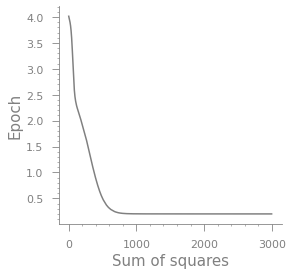

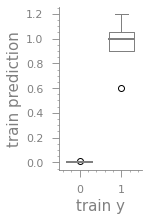

In [20]:
print(f'y:{np.squeeze(y)}\nPrediction: {np.squeeze(nn0.train_prediction)}')

nn0.plot_train_sum_of_squares()
nn0.boxplot_sum_of_squares_vs_class(dataset = 'train')

# MNIST dataset (handwritten digits)

Using TensorFlow backend.
C:\Users\mp674001\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mp674001\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mp674001\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mp674001\Anaconda3\lib\site-packages\tensorflow\python\framewo

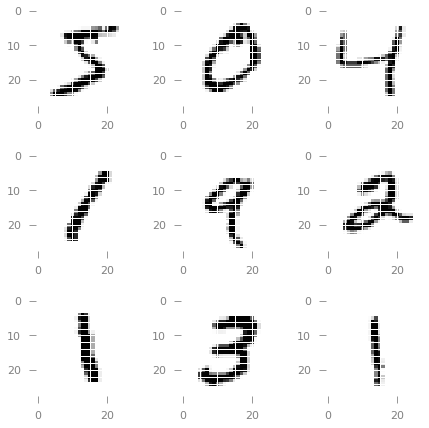

In [383]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

idx = np.random.choice(x_train.shape[0], 1000, replace = False)
n = 1000

x_train_sample = x_train[idx].reshape(n, x_train.shape[1]* x_train.shape[2]) / 255
y_train_sample = pd.get_dummies(y_train[idx]).values


x_test_sample = x_test.reshape(len(x_test), x_train.shape[1]* x_train.shape[2]) / 255
y_test_sample = pd.get_dummies(y_test).values

_, ax = plt.subplots(3,3, figsize = (6, 6), constrained_layout = True)
for i in range(9):
    ax.ravel()[i].imshow(x_train[i], cmap = 'Greys')
    for edge, spine in ax.ravel()[i].spines.items():
        spine.set_visible(False)

    for a in ax.ravel():
        a.grid(which = 'major', color='w', linestyle='-', linewidth=1)
        a.grid(which = 'minor', color='w', linestyle='-', linewidth=1)
        a.tick_params(which="minor", bottom=False, left=False)

del n, idx

Model fit with regularization

In [385]:
with TimeClass():
    nn1 = neural_network(hidden_layer_dimension = 40, epoch_size = 300, alpha = 0.005, batch_size = 10)
    print(nn1)
    nn1.fit(x_train_sample, y_train_sample)

        neural_network(        epoch_size = 300,         alpha = 0.005,         hidden_layer_dimension = 40,         dropout = True,         dropout_probability = 0.5,         seed = None         batch_size = 10        )
 Epoch:300/300, Error (Sum of sq.):87.22, Train accuracy:0.997
Finished executing in 14.73 seconds



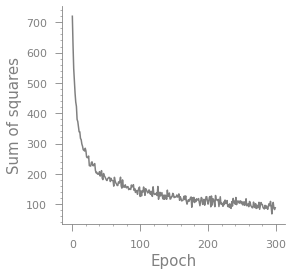

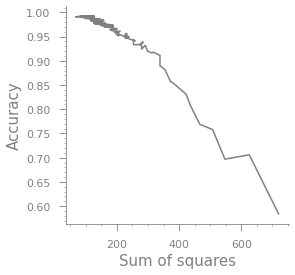

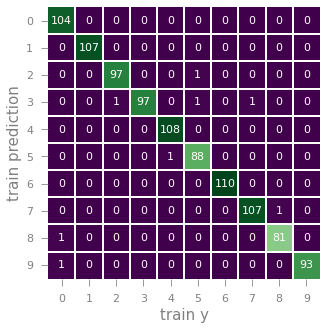

In [10]:
nn1.plot_train_sum_of_squares()
nn1.plot_train_sum_of_squares_vs_classification_accuracy()
nn1.classification_heatmap(dataset = 'train')

Test score:0.8544


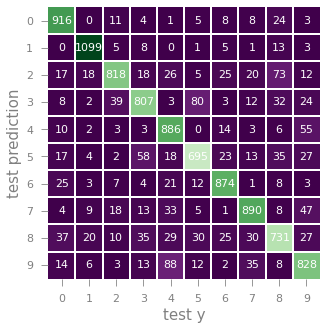

In [11]:
nn1.predict(x_test_sample)
nn1.score_prediction(y_test_sample)
print(f'Test score:{nn1.test_score}')
nn1.classification_heatmap(dataset = 'test')

Overfitting example (Dropout regularization deactivated)

In [13]:
with TimeClass():
    nn2 = neural_network(hidden_layer_dimension = 40, epoch_size = 300, alpha = 0.005, dropout = False, batch_size = 10)
    print(nn2)
    nn2.fit(x_train_sample, y_train_sample)

        neural_network(        epoch_size = 300,         alpha = 0.005,         hidden_layer_dimension = 40,         dropout = False,         dropout_probability = 0.5,         seed = None         batch_size = 10        )
 Epoch:300/300, Error (Sum of sq.):5.751, Train accuracy:0.997
Finished executing in 14.23 seconds



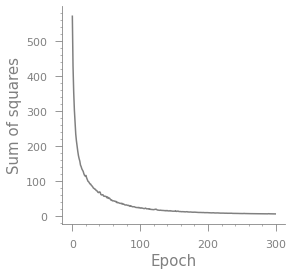

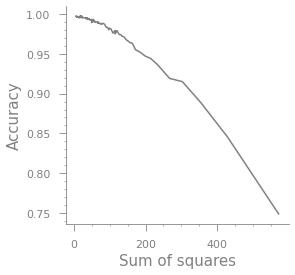

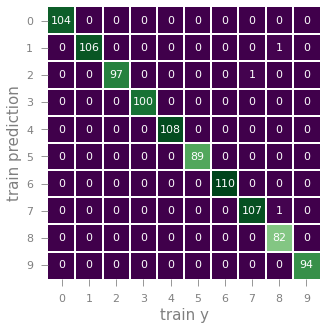

In [14]:
nn2.plot_train_sum_of_squares()
nn2.plot_train_sum_of_squares_vs_classification_accuracy()
nn2.classification_heatmap(dataset = 'train')

0.837


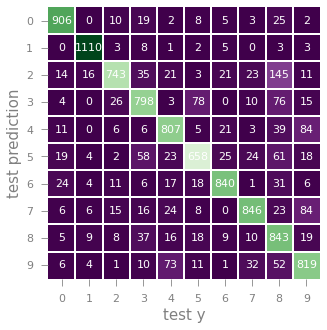

In [15]:
nn2.predict(x_test_sample)
nn2.score_prediction(y_test_sample)
print(nn2.test_score)
nn2.classification_heatmap(dataset = 'test')